## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.
> If it's exactly in between two options, select the higher value.

### Dataset

In this homework, we continue using the fuel efficiency dataset.
Download it from <a href='https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'>here</a>.

You can do it with wget:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
```

The goal of this homework is to create a regression model for predicting the car fuel efficiency (column `'fuel_efficiency_mpg'`).

In [2]:
# execute once
# ! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

### Preparing the dataset 

Preparation:

* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [ ]:
import pandas as pd

df = pd.read_csv("car_fuel_efficiency.csv")

missing = pd.concat([df.isna().sum(), df.dtypes], axis=1)
missing.columns = ["missing values", "data type"]
missing  # <- we see: only numerical columns have missing values

,missing values,data type
engine_displacement,0,int64
num_cylinders,482,float64
horsepower,708,float64
vehicle_weight,0,float64
acceleration,930,float64
model_year,0,int64
origin,0,object
fuel_type,0,object
drivetrain,0,object
num_doors,502,float64


In [14]:
df = df.fillna(0)
df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# split
test_size = 0.2
val_size = 0.2
df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=1)
df_train, df_val = train_test_split(
    df_full_train, test_size=val_size / (1 - test_size), random_state=1
)
dfs = {"full_train": df_full_train, "train": df_train, "val": df_val, "test": df_test}

# create Xs and ys
target = "fuel_efficiency_mpg"
ys = {key: df_.pop(target) for key, df_ in dfs.items()}
train_dicts = df_train.to_dict(orient="records")
dv = DictVectorizer(sparse=True)
dv.fit(train_dicts)
Xs = {key: dv.transform(df_.to_dict(orient="records")) for key, df_ in dfs.items()}

# quick sanity check
data = {
    "rel_df": [len(df_) / len(df) for df_ in dfs.values()],
    "abs_df": [len(df_) for df_ in dfs.values()],
    "abs_y": [len(y_) for y_ in ys.values()],
    "abs_X": [X_.shape[0] for X_ in Xs.values()],
    "df has target": [(target in df_.columns) for df_ in dfs.values()],
}
qsc = pd.DataFrame(
    data=data,
    index=[key for key in dfs.keys()],
)
print(qsc)

              rel_df  abs_df  abs_y  abs_X  df has target
full_train  0.799979    7763   7763   7763          False
train       0.599959    5822   5822   5822          False
val         0.200021    1941   1941   1941          False
test        0.200021    1941   1941   1941          False


## Question 1

Let's train a decision tree regressor to predict the `fuel_efficiency_mpg` variable. 

* Train a model with `max_depth=1`.

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(Xs["train"], ys["train"])

tree_rules = export_text(dt, feature_names=list(dv.get_feature_names_out()))
print(tree_rules)

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



Which feature is used for splitting the data?


* **`'vehicle_weight'`**
* `'model_year'`
* `'origin'`
* `'fuel_type'`

## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Training
dt = RandomForestRegressor(n_estimators=10, random_state=1)
dt.fit(Xs["train"], ys["train"])


# RMSE
y_pred = dt.predict(Xs["val"])
rmse = np.sqrt(mean_squared_error(ys["val"], y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.4596


What's the RMSE of this model on the validation data?

* 0.045
* **0.45**
* 4.5
* 45.0

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [83]:
def evaluate_random_forest(n_estimators, max_depth=None, n_jobs=None):
    """Train a RandomForestRegressor and return its RMSE on the validation dataset."""
    model = RandomForestRegressor(
        n_estimators=n_estimators, random_state=1, max_depth=max_depth, n_jobs=n_jobs
    )
    model.fit(Xs["train"], ys["train"])
    y_pred = model.predict(Xs["val"])
    return np.sqrt(mean_squared_error(ys["val"], y_pred))


# Define the range of n_estimators to test
n_estimators_list = range(10, 201, 10)
# Calculate RMSE for each value of n_estimators
rmse_scores = [evaluate_random_forest(n, n_jobs=-1) for n in n_estimators_list]

10: 0.46
20: 0.454
30: 0.452
40: 0.449
50: 0.447
60: 0.445
70: 0.445
80: 0.445
90: 0.445
100: 0.445
110: 0.444
120: 0.444
130: 0.444
140: 0.443
150: 0.443
160: 0.443
170: 0.443
180: 0.442
190: 0.442
200: 0.442


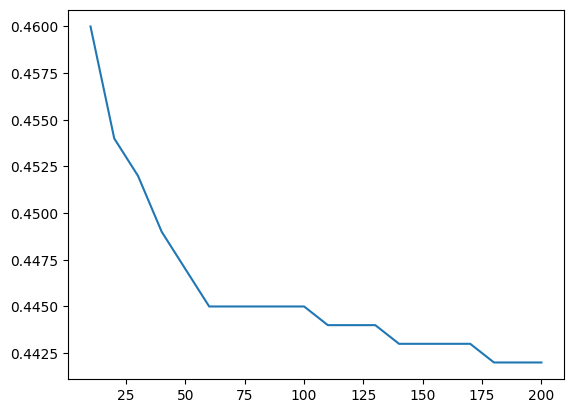

In [84]:
import seaborn as sns


# Plot the results
sns.lineplot(x=n_estimators_list, y=[round(s, 3) for s in rmse_scores])

for i, n_estimator in enumerate(n_estimators_list):
    print(f"{n_estimator}: {round(rmse_scores[i], 3)}")

After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- **200**

If it doesn't stop improving, use the latest iteration number in
your answer.

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`

In [91]:
max_depth_list = range(10, 25 + 1, 5)
n_estimators_list = range(10, 200 + 1, 10)

mean_rmse_scores = [
    np.mean(
        [evaluate_random_forest(n, max_depth=m, n_jobs=-1) for n in n_estimators_list]
    )
    for m in max_depth_list
]

10: 0.4418
15: 0.4454
20: 0.4463
25: 0.4459


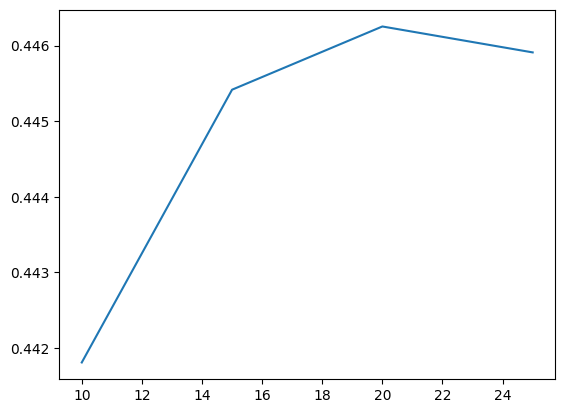

In [ ]:
# Plot the results
sns.lineplot(x=max_depth_list, y=mean_rmse_scores)

for i, max_depth in enumerate(max_depth_list):
    print(f"{max_depth}: {round(rmse_scores[i], 4)}")

What's the best `max_depth`, using the mean RMSE?

* **10**
* 15
* 20
* 25

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model



In [99]:
# Training
dt = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1)
dt.fit(Xs["train"], ys["train"])

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [103]:
feature_names = dv.get_feature_names_out()
feature_importances = dt.feature_importances_

feature_importances = {
    feature: feature_importances[i] for i, feature in enumerate(feature_names)
}

sorted_feature_importances = dict(
    sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)
)

sorted_feature_importances

{'vehicle_weight': np.float64(0.9591499647407432),
 'horsepower': np.float64(0.015997897714266237),
 'acceleration': np.float64(0.01147970063142938),
 'engine_displacement': np.float64(0.0032727919136094864),
 'model_year': np.float64(0.003212300094794675),
 'num_cylinders': np.float64(0.0023433469524512048),
 'num_doors': np.float64(0.0016349895439306998),
 'origin=USA': np.float64(0.0005397216891829147),
 'origin=Europe': np.float64(0.000518739638586969),
 'origin=Asia': np.float64(0.0004622464955097423),
 'fuel_type=Gasoline': np.float64(0.00036038360069172865),
 'drivetrain=All-wheel drive': np.float64(0.0003571085493021933),
 'drivetrain=Front-wheel drive': np.float64(0.00034538411263183535),
 'fuel_type=Diesel': np.float64(0.000325424322869738)}


What's the most important feature (among these 4)? 

* **`vehicle_weight`**
*	`horsepower`
* `acceleration`
* `engine_displacement`	

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

In [112]:
# install once
#!pip install xgboost

In [114]:
import xgboost as xgb

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(Xs["train"], label=ys["train"], feature_names=features)
dval = xgb.DMatrix(Xs["val"], label=ys["val"], feature_names=features)
watchlist = [(dtrain, "train"), (dval, "val")]

xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

print("model with η = 0.3")
model_0_3 = xgb.train(
    xgb_params, dtrain, num_boost_round=100, verbose_eval=10, evals=watchlist
)

print("model with η = 0.1")
xgb_params["eta"] = 0.1
model_0_1 = xgb.train(
    xgb_params, dtrain, num_boost_round=100, verbose_eval=10, evals=watchlist
)

model with η = 0.3
[0]	train-rmse:1.81393	val-rmse:1.85444


[10]	train-rmse:0.37115	val-rmse:0.43896
[20]	train-rmse:0.33553	val-rmse:0.43376
[30]	train-rmse:0.31475	val-rmse:0.43752
[40]	train-rmse:0.30202	val-rmse:0.43968
[50]	train-rmse:0.28456	val-rmse:0.44140
[60]	train-rmse:0.26768	val-rmse:0.44290
[70]	train-rmse:0.25489	val-rmse:0.44531
[80]	train-rmse:0.24254	val-rmse:0.44689
[90]	train-rmse:0.23193	val-rmse:0.44839
[99]	train-rmse:0.21950	val-rmse:0.45018
model with η = 0.1
[0]	train-rmse:2.28944	val-rmse:2.34561
[10]	train-rmse:0.91008	val-rmse:0.94062
[20]	train-rmse:0.48983	val-rmse:0.53064
[30]	train-rmse:0.38342	val-rmse:0.44289
[40]	train-rmse:0.35343	val-rmse:0.42746
[50]	train-rmse:0.33998	val-rmse:0.42498
[60]	train-rmse:0.33054	val-rmse:0.42456
[70]	train-rmse:0.32202	val-rmse:0.42503
[80]	train-rmse:0.31667	val-rmse:0.42563
[90]	train-rmse:0.31059	val-rmse:0.42586
[99]	train-rmse:0.30419	val-rmse:0.42623


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* **0.1**
* Both give equal value

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw06
* If your answer doesn't match options exactly, select the closest one. If the answer is exactly in between two options, select the higher value.